In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import sys
sys.path.append('../domain')  # Ajustez le chemin relatif si nécessaire

from forcast import encode_target, split_data, evaluate_model, cross_validate, preprocess_data


In [4]:
print(df .dtypes)

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object


In [5]:
print(df)

     Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own             NaN           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little              NaN           2096   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
..   ...     ...  ...     ...             ...              ...            ...   
995   31  female    1     own          little              NaN           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little              NaN            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              

In [6]:
display(df)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


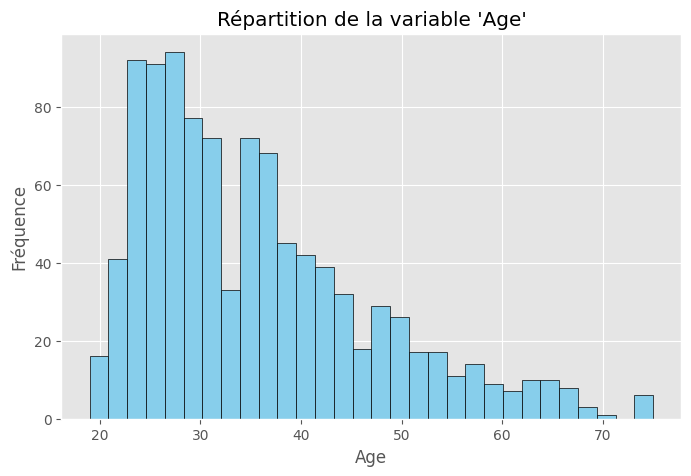

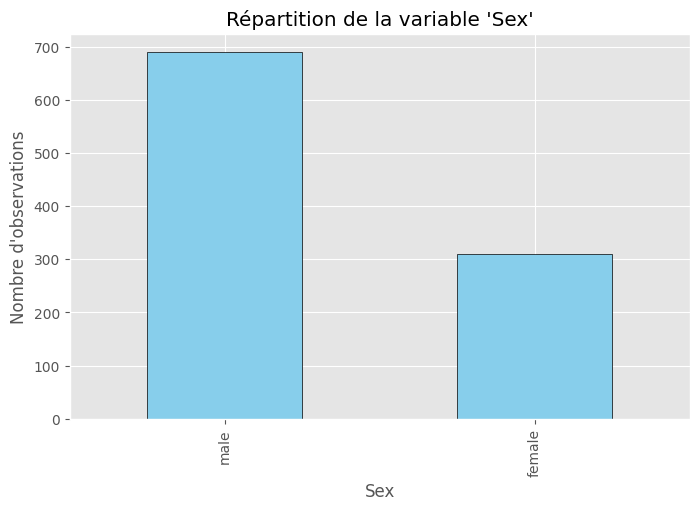

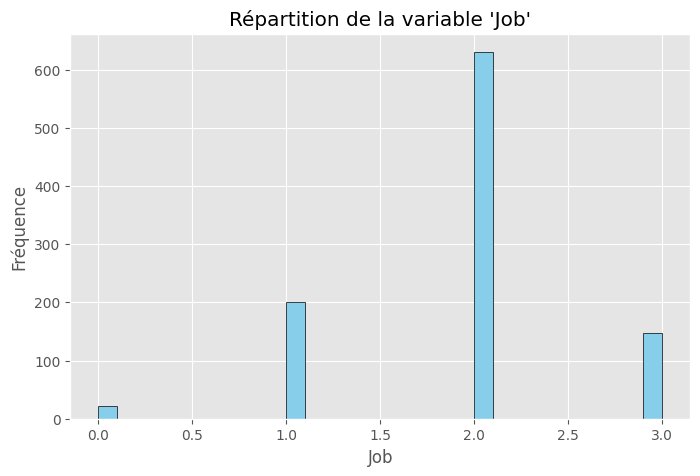

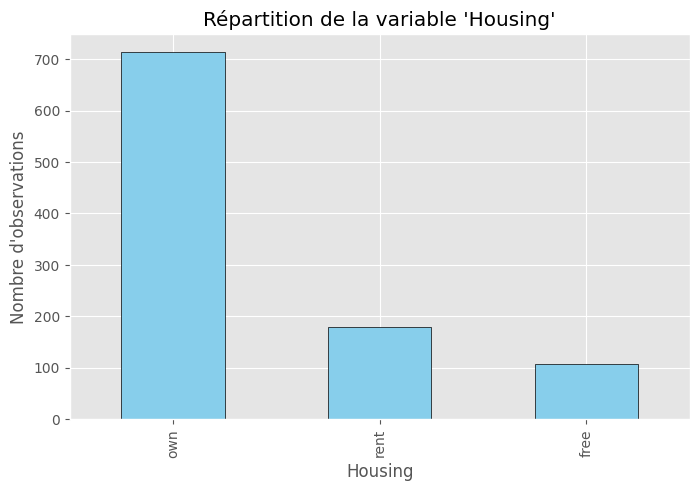

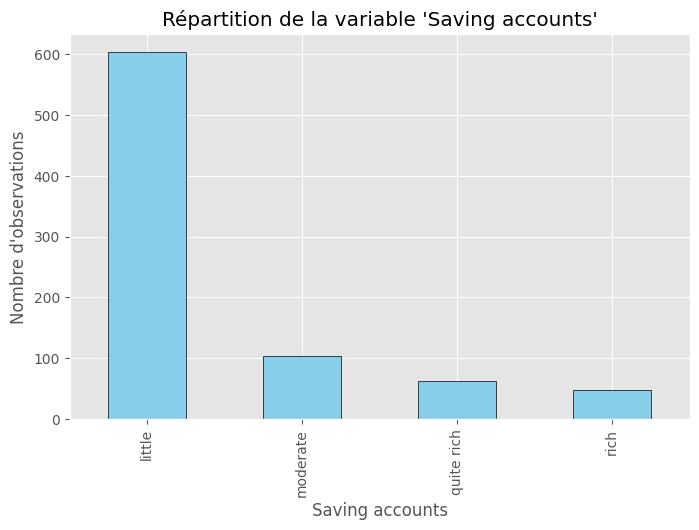

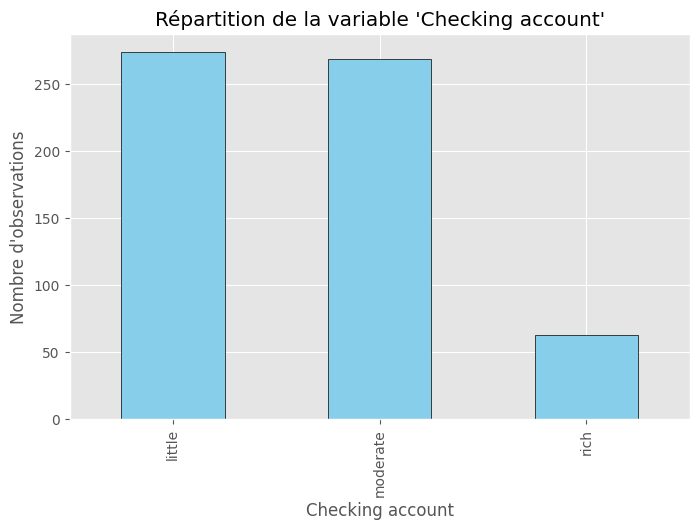

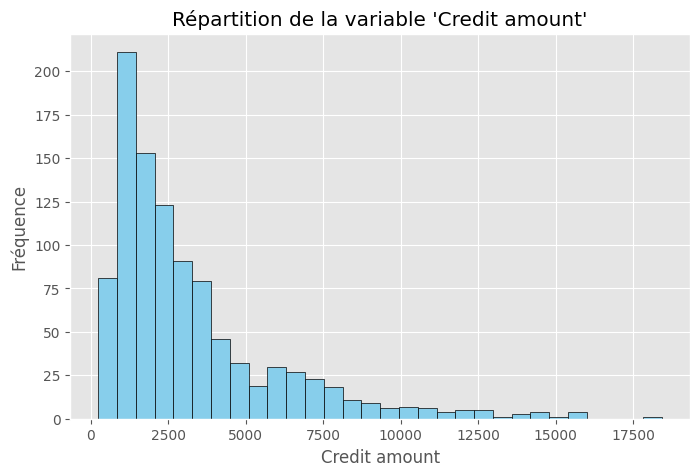

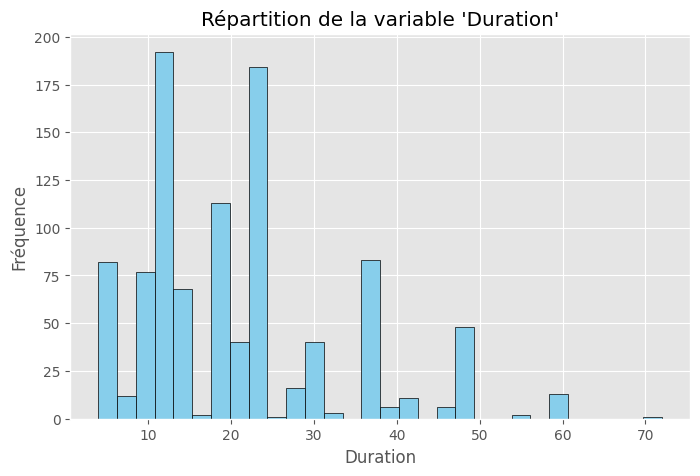

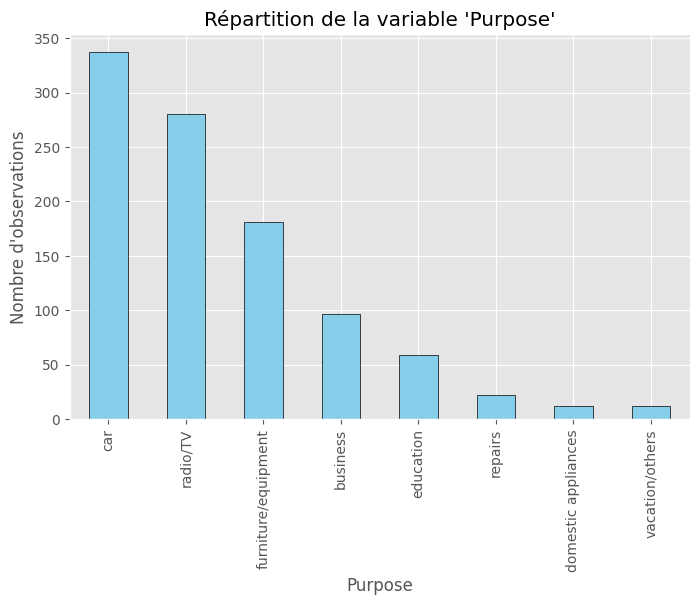

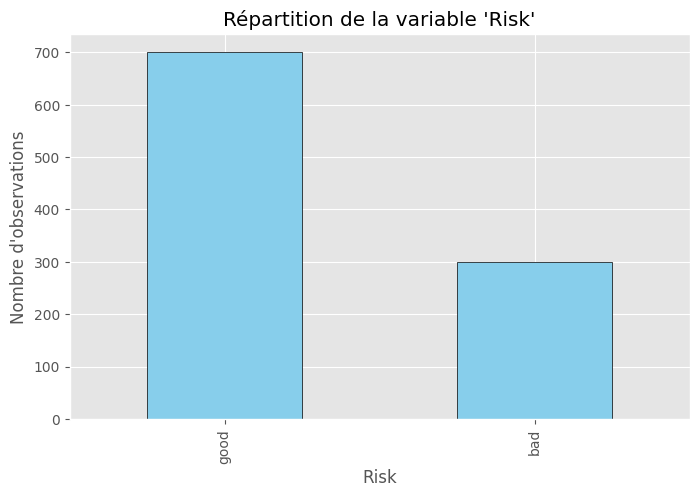

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


# Supprimer la colonne Unnamed: 0 si elle existe
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

# Créer des histogrammes pour chaque variable
plt.style.use('ggplot')  # Style pour un affichage plus agréable

for column in df.columns:
    plt.figure(figsize=(8, 5))  # Taille de chaque histogramme
    if df[column].dtype in ['int64', 'float64']:
        # Histogramme pour variables numériques
        plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
        plt.title(f"Répartition de la variable '{column}'")
        plt.xlabel(column)
        plt.ylabel("Fréquence")
    else:
        # Diagramme en barres pour variables catégorielles
        df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Répartition de la variable '{column}'")
        plt.xlabel(column)
        plt.ylabel("Nombre d'observations")
    plt.show()


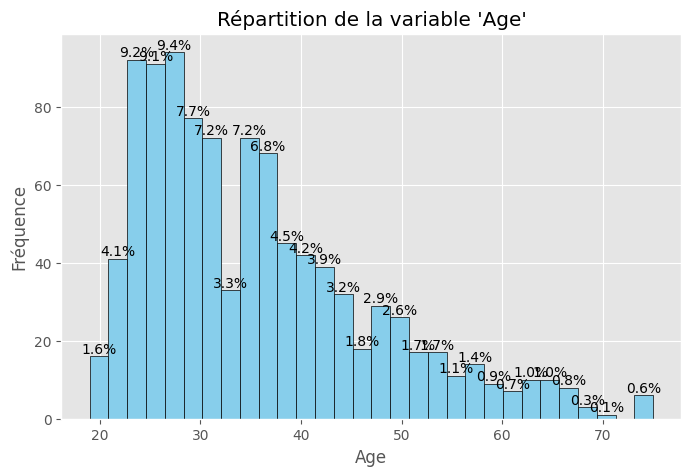

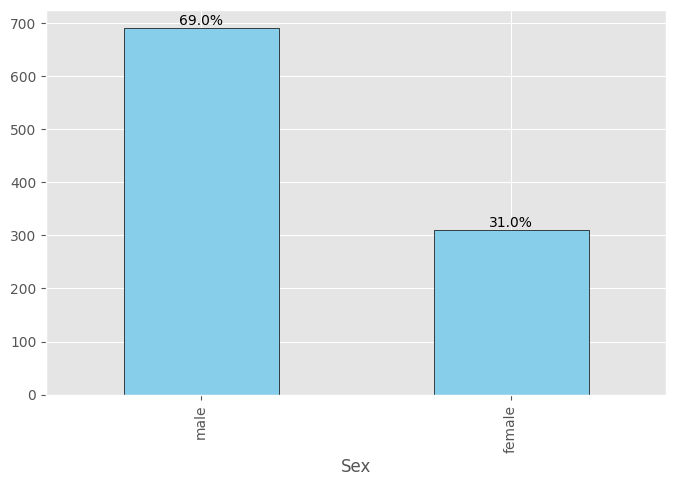

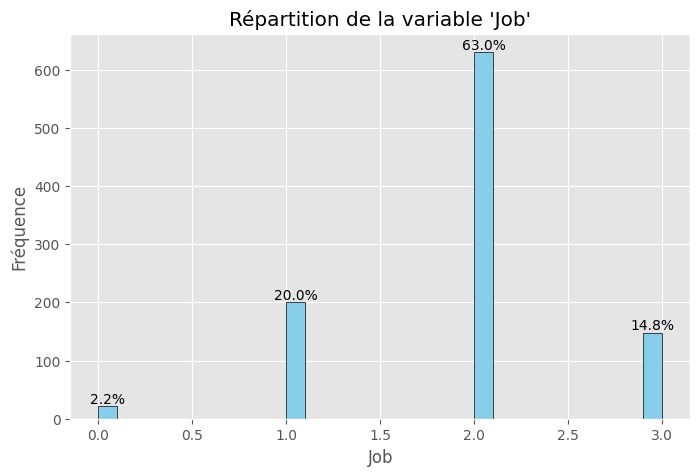

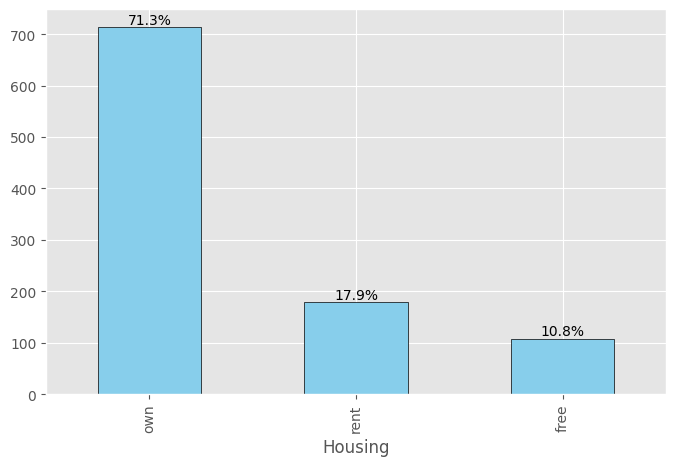

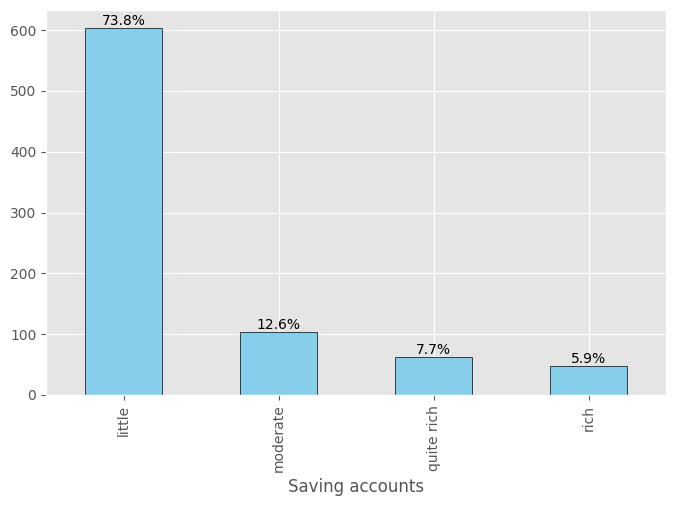

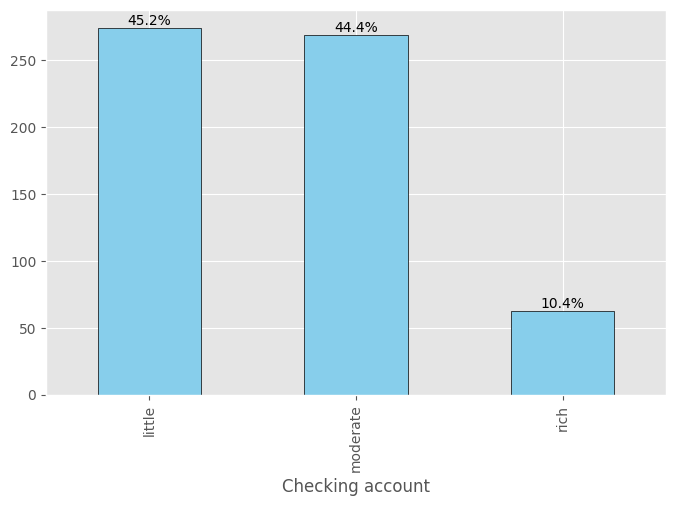

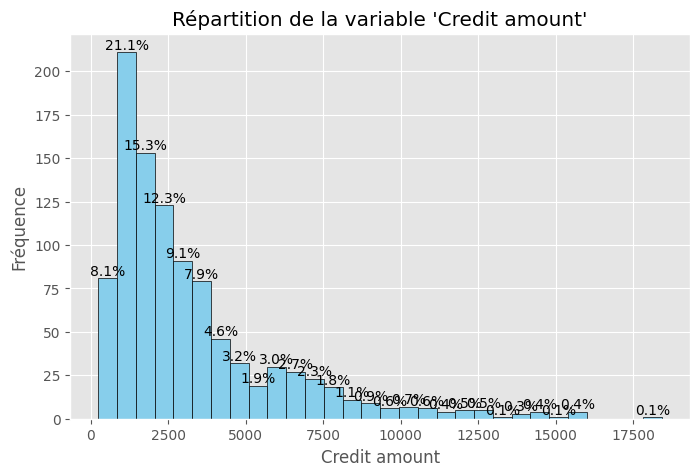

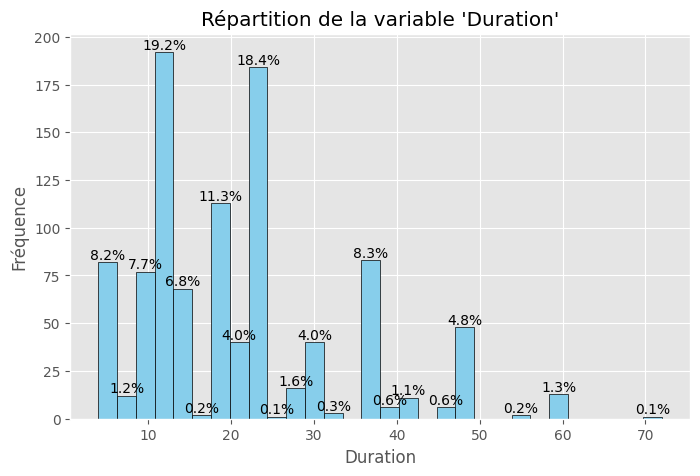

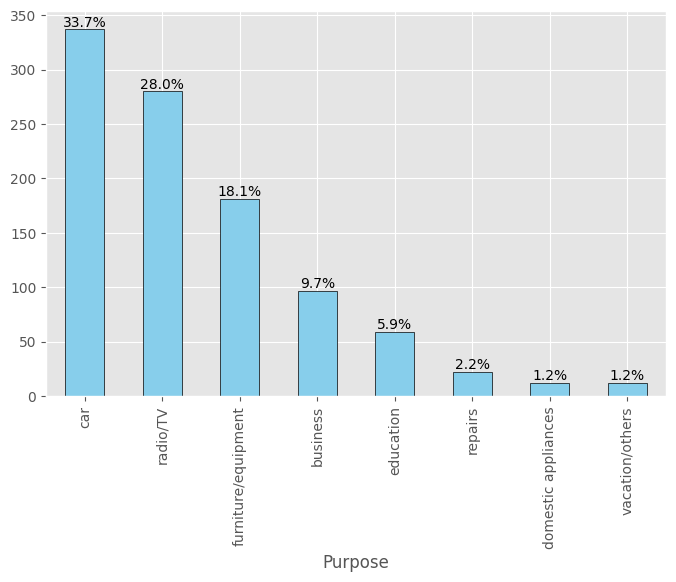

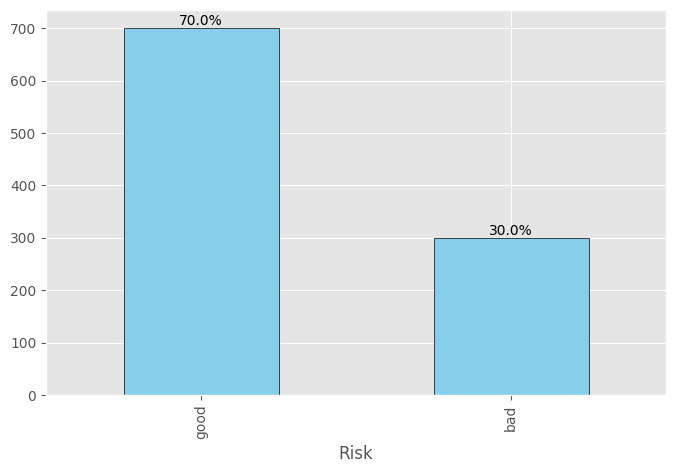

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Supprimer la colonne Unnamed: 0 si elle existe
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

# Style d'affichage
plt.style.use('ggplot')  # Style pour un affichage plus agréable

# Fonction pour ajouter les pourcentages sur les barres
def add_percentage(ax, total):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Éviter les barres vides
            percentage = f"{(height / total) * 100:.1f}%"  # Calcul du pourcentage
            ax.annotate(percentage, 
                        (p.get_x() + p.get_width() / 2, height),  # Position
                        ha='center', va='bottom', fontsize=10, color='black')

# Créer des histogrammes pour chaque variable
for column in df.columns:
    plt.figure(figsize=(8, 5))  # Taille de chaque histogramme
    if df[column].dtype in ['int64', 'float64']:
        # Variables numériques
        counts, bins, patches = plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
        total = counts.sum()
        
        # Ajouter des pourcentages
        for count, patch in zip(counts, patches):
            if count > 0:  # Pour éviter les barres vides
                percentage = f"{(count / total) * 100:.1f}%"
                plt.text(patch.get_x() + patch.get_width() / 2, count, percentage,
                         ha='center', va='bottom', fontsize=10, color='black')
        
        plt.title(f"Répartition de la variable '{column}'")
        plt.xlabel(column)
        plt.ylabel("Fréquence")

    else:
        # Variables catégorielles
        value_counts = df[column].value_counts()
        total = value_counts.sum()
        ax = value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        
        # Ajouter les pourcentages
        add_percentage(ax, total)
  


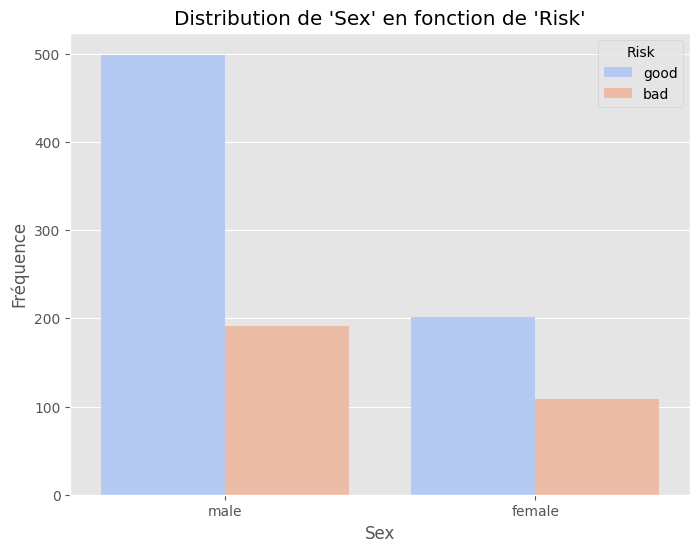

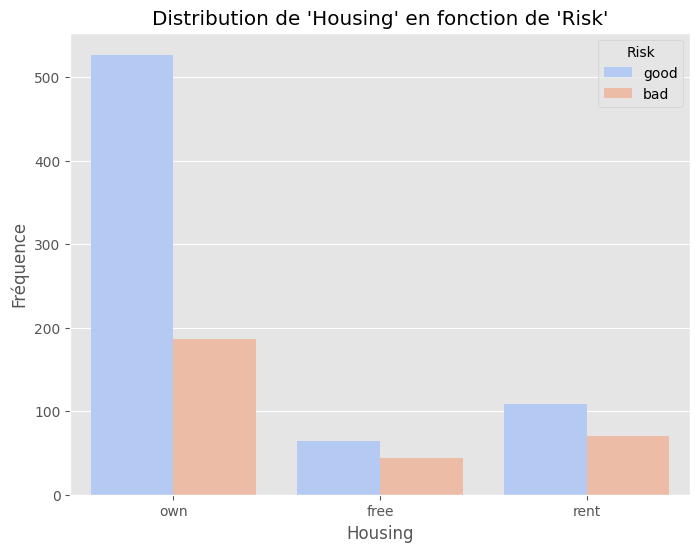

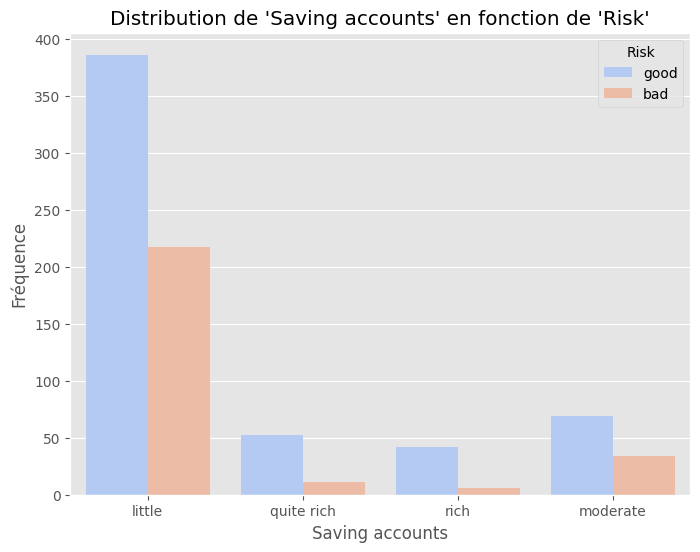

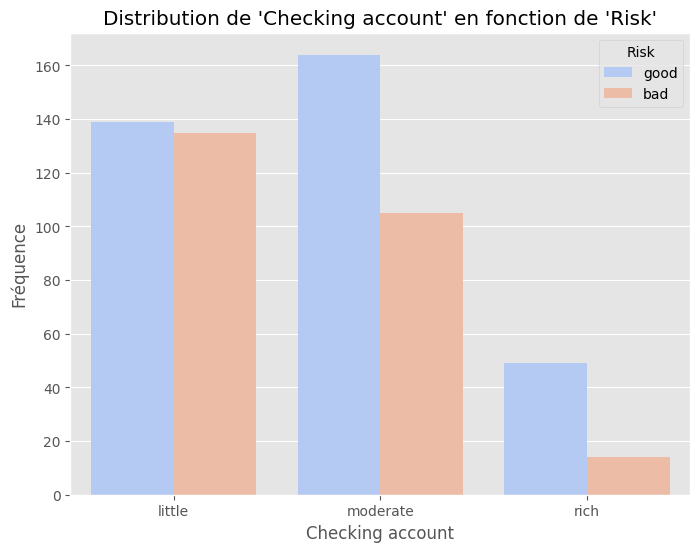

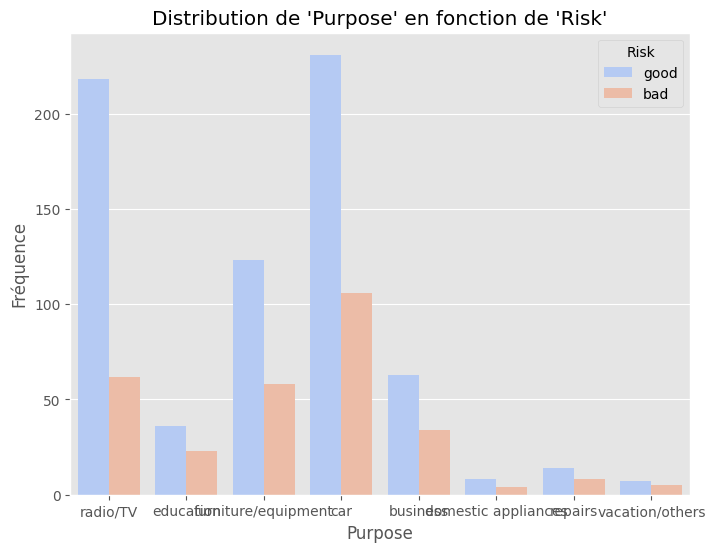

C:\Users\ilysd\AppData\Local\Temp\ipykernel_61540\1606279844.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Risk")


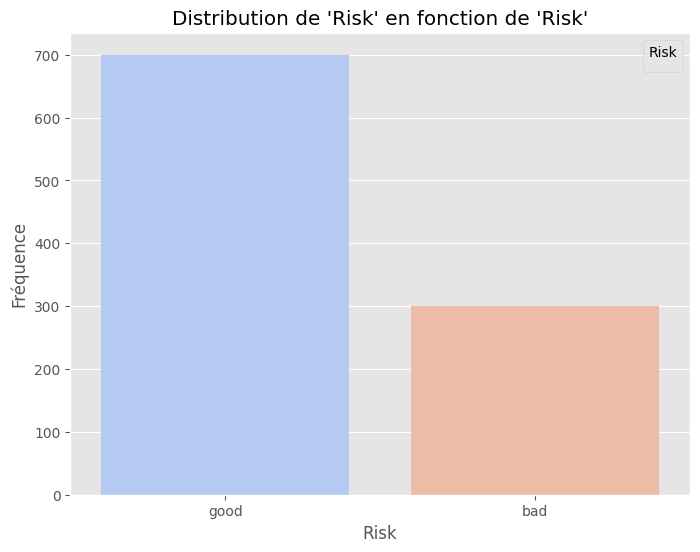

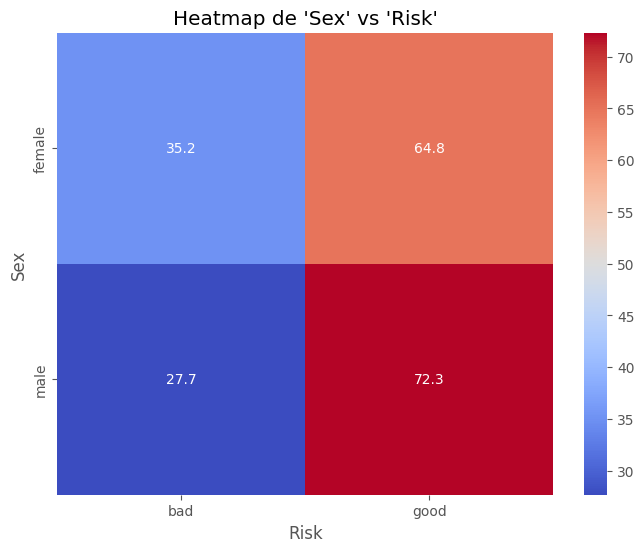

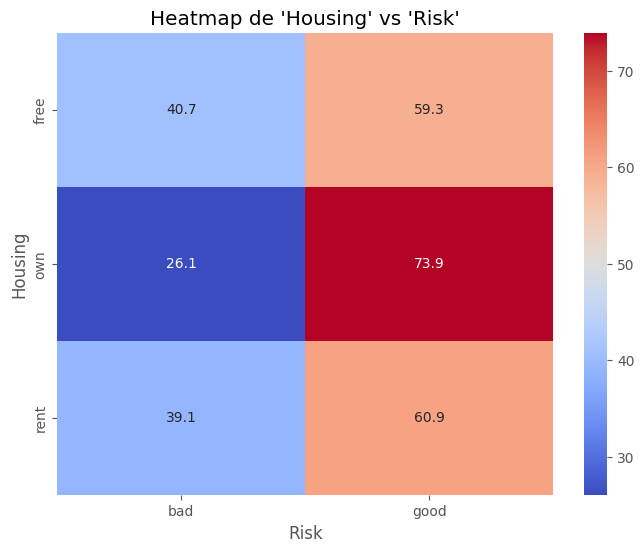

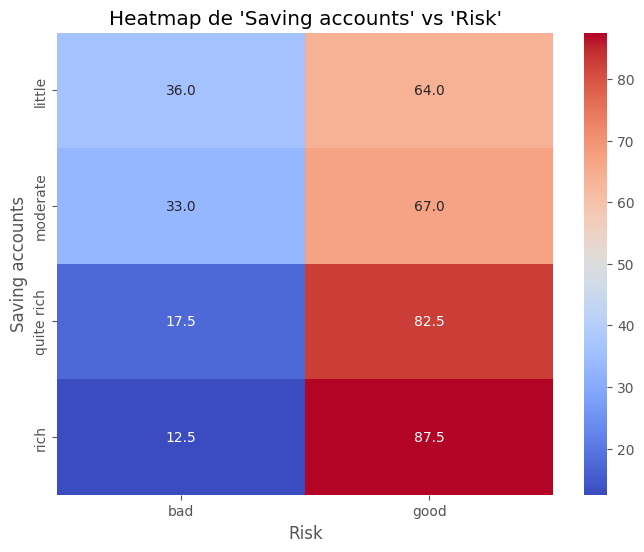

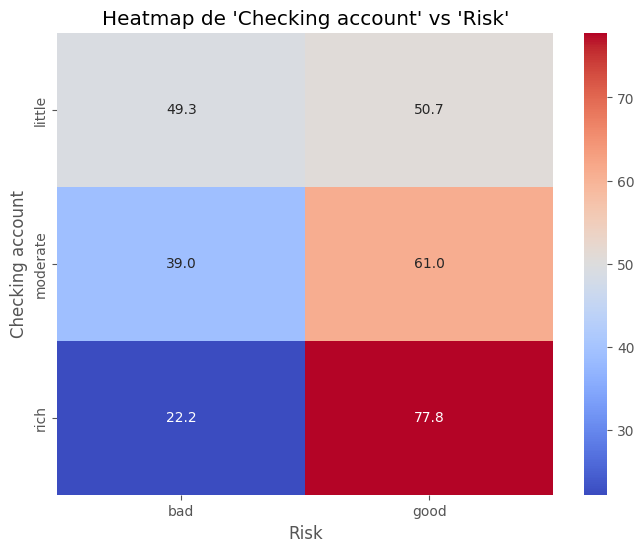

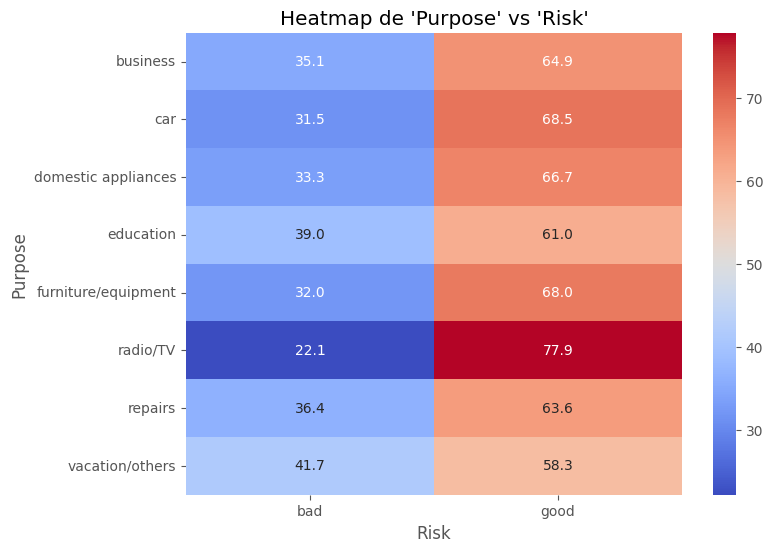

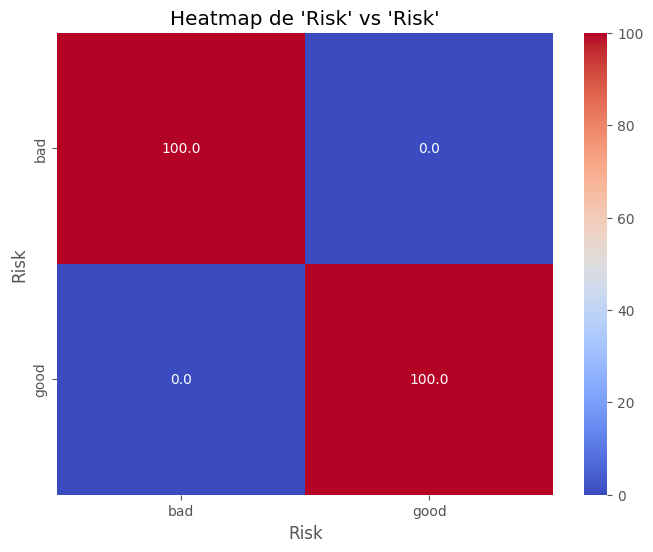

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Liste dynamique des variables catégorielles du DataFrame
cat_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Si tu veux ajouter des variables spécifiques qui ne sont pas détectées automatiquement
# cat_vars.extend(['Sex', 'Job', 'Housing']) # Ajouter d'autres variables à la liste si nécessaire

# 1. Histogrammes empilés pour chaque variable catégorielle en fonction de 'Risk'
for var in cat_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=var, hue='Risk', data=df, palette='coolwarm')
    plt.title(f"Distribution de '{var}' en fonction de 'Risk'")
    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.legend(title="Risk")
    plt.show()

# 2. Heatmap de la table de contingence (crosstab) pour chaque variable catégorielle
for var in cat_vars:
    # Création de la table de contingence normalisée
    contingency_table = pd.crosstab(df[var], df['Risk'], normalize='index') * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt=".1f", cmap="coolwarm")
    plt.title(f"Heatmap de '{var}' vs 'Risk'")
    plt.xlabel("Risk")
    plt.ylabel(var)
    plt.show()


In [10]:
valeurs_manquantes_pourcentage = (df.isna().sum()/len(df))*100
print(valeurs_manquantes_pourcentage)

Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
Risk                 0.0
dtype: float64


# features engineering

In [11]:
df['Saving accounts'] = df['Saving accounts'].fillna('No savings')

df['Checking account'] = df['Checking account'].fillna('No checking')

#Convertir en float pour éviter les conflits de types avec pd.cut()
df['Age'] = df['Age'].astype(float)
df['Credit amount'] = df['Credit amount'].astype(float)


#Creation d'une nouvelle colonne interactive entre credit amount et duration avant leurs encodages
df['Credit_Duration_Ratio'] = df['Credit amount'] / df['Duration']

# Définir les tranches d'âge
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, float('inf')], labels=['Young', 'Adults', 'Mature-Seniors'], right=False)


df['Credit amount'] = pd.cut(
    df['Credit amount'], 
    bins=[0, 2500, 5000, float('inf')], 
    labels=['Small', 'Moderate', 'Big']
)


df.drop(columns=['Checking account', 'Saving accounts', 'Age'], inplace=True)




# Cramer

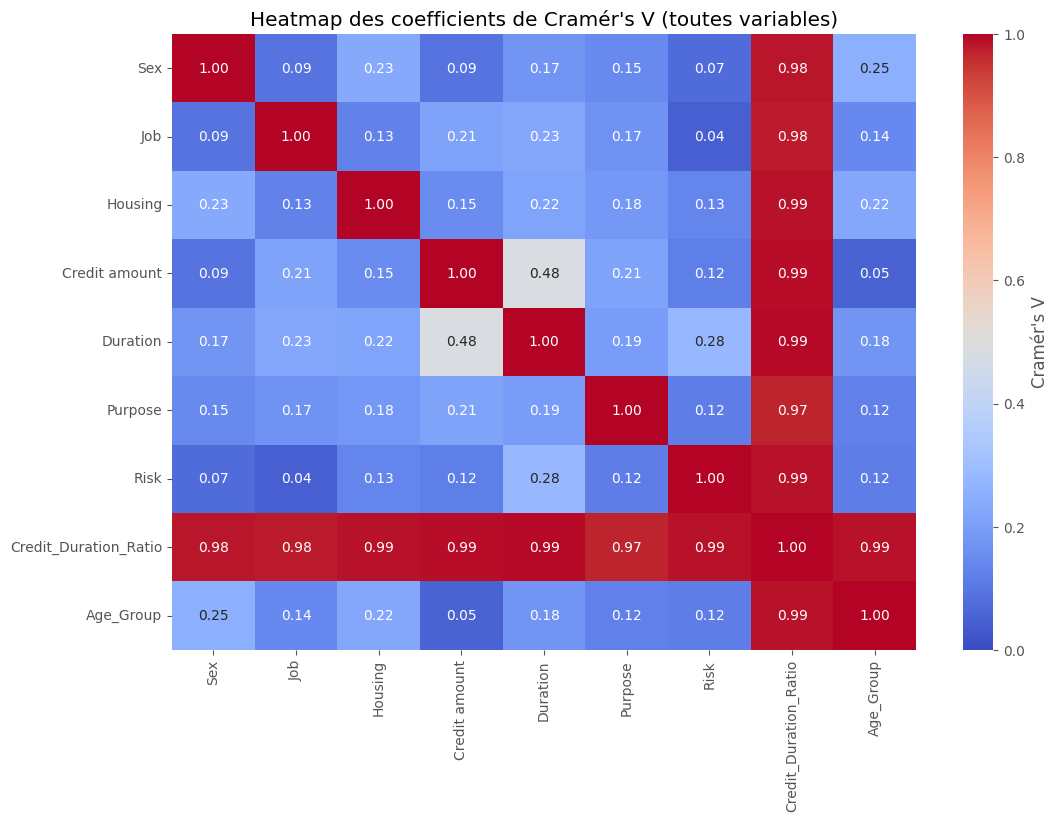

In [12]:
# Fonction pour calculer Cramér's V
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Utilisation de toutes les variables du DataFrame
all_vars = df.columns

# Calcul de Cramér's V entre chaque paire de variables
cramers_v_matrix = []

for var1 in all_vars:
    row = []
    for var2 in all_vars:
        if var1 == var2:
            row.append(1.0)  # Cramér's V est toujours 1 avec soi-même
        else:
            # Calcul de Cramér's V
            confusion_matrix = pd.crosstab(df[var1], df[var2])
            v = cramers_v(confusion_matrix)
            row.append(v)
    cramers_v_matrix.append(row)

# Convertir en DataFrame pour une meilleure lisibilité
cramers_v_df = pd.DataFrame(cramers_v_matrix, columns=all_vars, index=all_vars)

# Affichage de la heatmap pour Cramér's V
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_df, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': "Cramér's V"}, vmin=0, vmax=1)
plt.title("Heatmap des coefficients de Cramér's V (toutes variables)")
plt.show()

In [14]:
X = df.drop(columns=['Risk'])  # Remplace 'cible' par le nom de ta colonne cible
y = df['Risk']  # Colonne cible

In [15]:

# Applique l'encodage one-hot
X_processed = preprocess_data(X)

# Exemple d'utilisation
y_encoded = encode_target(y)  # Pour encoder la variable cible
X_train, X_test, y_train, y_test = split_data(X_processed, y)  # Pour séparer les données en ensembles d'entraînement et de test
grid_search = cross_validate()  # Pour définir la grille de recherche pour le RandomForest
evaluate_model(grid_search, X_train, y_train, X_test, y_test)  # Pour évaluer le modèle avec les meilleures hyperparamètres


Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.7306666666666667

Test Set Performance:
               precision    recall  f1-score   support

         bad       0.48      0.17      0.25        75
        good       0.72      0.92      0.81       175

    accuracy                           0.70       250
   macro avg       0.60      0.55      0.53       250
weighted avg       0.65      0.70      0.64       250

